# *Tutorial. LISA and $\gamma$-ray telescopes as multi-messenger probes of a first-order cosmological phase transition*

### Tutorial that shows how to use [**CosmoGW**](https://github.com/CosmoGW/CosmoGW) to compute the GW spectrum from sound waves and turbulence in a first-order phase transition.

### It follows the description presented in [RoperPol:2023bqa]: "LISA and γ-ray telescopes as multi-messenger probes of a first-order cosmological phase transition," *A. Roper Pol, A. Neronov, C. Caprini, T. Boyer and D. Semikoz*,  [arXiv:2307.10744](https://arxiv.org/abs/2307.10744) (2023)

### Created by Alberto Roper Pol (alberto.roperpol@unige.ch), 23/07/2025

In [1]:
## Install CosmoGW from https://pypi.org/project/cosmoGW/
# !pip install cosmoGW

## Make sure to have latex installed for plots, the following is
## required when executing from google colab

# !sudo apt-get update
# !sudo apt-get install -y cm-super dvipng texlive-latex-extra texlive-latex-recommended

### Comprehensive documentation of [**CosmoGW**](https://pypi.org/project/cosmoGW/) is available at [Read the Docs](https://cosmogw-manual.readthedocs.io/).

In [1]:
from cosmoGW import cosmology, GW_templates, plot_sets, interferometry, hydro_bubbles, GW_back, analysis, GW_models
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u

cmap = plt.get_cmap('rainbow_r')
darken_factor = .9  # Adjust this factor to control darkness

cs2 = 1/3             # default value for sound speed squared is 1/3
cs  = np.sqrt(cs2)

# directory to save figures
dirr_figs = 'GWs_MFs_from_FOPT/'
plot_sets.ensure_dir('plots/' + dirr_figs)

### We compute the GW background using the models presented in RoperPol:2023bqa for sound waves and turbulence, available in **CosmoGW** by the functions *OmGW_spec_sw* and *OmGW_spec_turb*

In [2]:
# Phase transition parameters
alpha    = 0.5
beta     = 10
vw       = 0.95
eps_turb = 1
T        = 100*u.GeV

# relativistic and adiabatic degrees of freedom
g  = cosmology.thermal_g(T=T, s=0, file=True)
gS = cosmology.thermal_g(T=T, s=1, file=True)

# Range of frequencies, normalized by the mean bubble separation, s = f R_ast
s = np.logspace(-3, 4, 1000)

# Spectrum from sound waves using SSM (Hindmarsh:2019phv)
freqs_sw, OmGW_sw = \
        GW_templates.OmGW_spec_sw(s, alpha, beta, vws=vw, expansion=True, Nsh=1.,
                                  model_efficiency='fixed_value', model_K0='Espinosa',
                                  model_decay='sound_waves', model_shape='sw_SSM',
                                  redshift=True, gstar=g, gS=gS, T=T)

# Spectrum from sound waves using fit based on HL simulations (RoperPol:2023bqa, Jinno:2022mie)
freqs_sw_HL, OmGW_sw_HL = \
        GW_templates.OmGW_spec_sw(s, alpha, beta, vws=vw, expansion=True, Nsh=1.,
                                  model_efficiency='fixed_value', model_K0='Espinosa',
                                  model_decay='sound_waves', model_shape='sw_HL',
                                  redshift=True, gstar=g, gS=gS, T=T)

# Spectrum from MHD turbulence based on the constant-in-time model (RoperPol:2023bqa, Jinno:2022mie)
freqs_turb, OmGW_turb = \
        GW_templates.OmGW_spec_turb_alphabeta(s, alpha, beta, vws=vw,
                                              eps_turb=eps_turb, redshift=True,
                                              gstar=g, gS=gS, T=T)

## LISA PLS with SNR = 10 and 4 years of observation
f_LISA, OmLISA, LISA_OmPLS = interferometry.read_sens(SNR=10, T=4)

### For illustration, let's generate the plot of the GW spectra for a particular phase transition, described by the parameters $\alpha = 0.5$, $\beta/H_\ast = 10$, $v_w =0.95$, $\varepsilon_{\rm turb} = 1$, $T_\ast = 100$ GeV

SNR:  977.7918584896013
Figure already exists: GW_turb_sws_example.png
Comparing output to existing figure
Images are within the allowed tolerance (0.01)
Images are within the allowed tolerance (0.01)


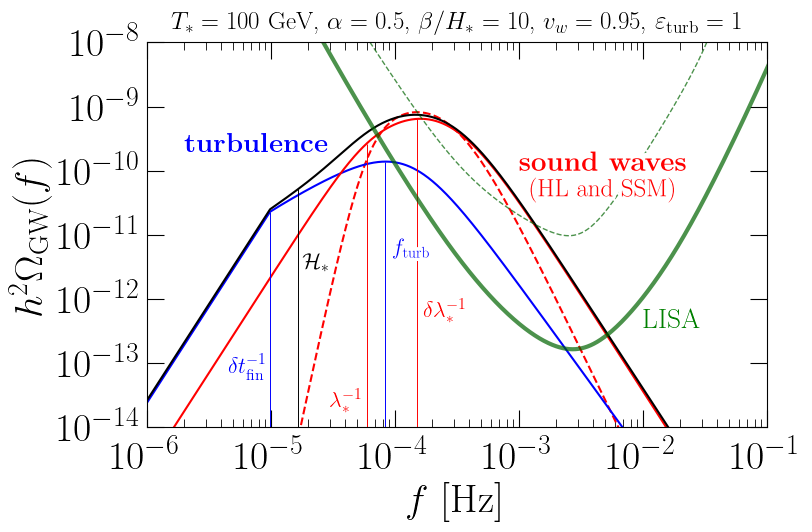

In [3]:
import matplotlib.patheffects as pe

plt.figure(figsize=(8,5))

# plot GWB from sound waves and turbulence
plt.loglog(freqs_sw, OmGW_sw, color='red', ls='dashed')
plt.loglog(freqs_turb, OmGW_turb, color='blue')
plt.loglog(freqs_sw_HL, OmGW_sw_HL, color='red')

# plot GWB of the sum
plt.loglog(freqs_sw_HL, OmGW_sw_HL + OmGW_turb, color='black')
plot_sets.axes_lines()

# SNR for this signal
print('SNR: ', interferometry.SNR(freqs_sw_HL, OmGW_sw_HL + OmGW_turb,
                                  f_LISA, OmLISA, T=4))

plt.xlim(1e-6, 1e-1)
plt.ylim(1e-14, 1e-8)
plt.yticks(np.logspace(-14, -8, 7))
plt.xticks(np.logspace(-6, -1, 6))

str_tit =  r'$T_\ast = %.0f$ GeV, $\alpha = %.1f$,'%(T.value, alpha)
str_tit += r' $\beta/H_\ast = %.0f$, $v_w = %.2f$,'%(beta, vw)
str_tit += r' $\varepsilon_{\rm turb} = %.0f$'%(eps_turb)
plt.title(str_tit, fontsize=18, pad=10)

# ## Hubble scale
Hs = cosmology.Hs_val(g=g, T=T)*cosmology.as_a0_rat(g=g, T=T)
plt.vlines(Hs.value, 1e-15, np.interp(Hs.value, freqs_turb.value, OmGW_turb + OmGW_sw_HL),
           color='black', lw=.7)
plt.text(1.8e-5, 3e-12, r'${\cal H}_*$', color='black', fontsize=16,
         path_effects=[pe.withStroke(linewidth=5, foreground='w')])

## fluid length scales in sound waves
lf = hydro_bubbles.Rstar_beta(vws=vw, corr=True)/beta
plt.vlines(Hs.value/lf, 1e-15, np.interp(Hs.value/lf, freqs_sw_HL.value, OmGW_sw_HL),
           color='red', lw=.7)
plt.text(3e-5, 2e-14, r'$\lambda_*^{-1}$', color='red', fontsize=16)

Dw = abs(vw - cs)/vw        # sound-shell thickness
plt.vlines(Hs.value/lf/Dw, 1e-15, np.interp(Hs.value/lf/Dw, freqs_sw_HL.value, OmGW_sw_HL),
           color='red', lw=.7)
plt.text(1.7e-4, 5e-13, r'$\delta \lambda_*^{-1}$', color='red', fontsize=16)

## spectral peak position of the turbulence spectrum fturb
_, fGW, _ = GW_templates.pPi_fit(1)
plt.vlines(Hs.value/lf*fGW, 1e-15, np.interp(Hs.value/lf*fGW, freqs_turb.value, OmGW_turb),
           color='blue', lw=.7)
plt.text(9.5e-5, 5e-12, r'$f_{\rm turb}$', color='blue', fontsize=16,
         path_effects=[pe.withStroke(linewidth=5, foreground='w')])

## position of the spectral break at the inverse duration of turbulence
Om = .5*hydro_bubbles.kappas_Esp(vw, alpha)*alpha/(1 + alpha)*eps_turb
dtfin = GW_models.N_turb/np.sqrt(2*Om/(1 + cs2))
plt.vlines(Hs.value/lf/dtfin, 1e-15, np.interp(Hs.value/lf/dtfin, freqs_turb.value, OmGW_turb),
           color='blue', lw=.7)
plt.text(4.5e-6, 7e-14, r'$\delta t_{\rm fin}^{-1}$', color='blue', fontsize=16)

plt.text(1e-3, 1e-10,   r'{\bf sound waves}', color='red',
         path_effects=[pe.withStroke(linewidth=8, foreground='w')])
plt.text(1.2e-3, 4e-11, r'(HL and SSM)', color='red', fontsize=18,
         path_effects=[pe.withStroke(linewidth=5, foreground='w')])
plt.text(2e-6, 2e-10,   r'{\bf turbulence}', color='blue')
plt.text(1e-2, 3.5e-13, r'{LISA}', color='green', fontsize=20)

plt.xlabel('$f$ [Hz]')
plt.ylabel(r'$h^2 \Omega_{\rm GW} (f)$')

plt.plot(f_LISA, OmLISA, lw=1, alpha=.7, color='darkgreen', ls='dashed')
plt.plot(f_LISA, LISA_OmPLS, lw=3, alpha=.7, color='darkgreen')

plot_sets.save_fig(name='GW_turb_sws_example')

In [ ]:
alphas = np.logspace(-3, 0,  4)
betas  = np.logspace(0, 3.2, 3)
TTs    = np.logspace(0, 6, 13)*u.GeV
vws    = np.linspace(0.4, .999, 13)

eps_turb = np.array([1e-10, 0.1, 1])

SNR = analysis.analysis_LISA_alphabeta(
    s, alphas, betas, vws, TTs, eps_turb=eps_turb, model_shape='sw_HL', turb=True
)

Computing spectra for eps_turb = 0.0
Computing spectra for eps_turb = 0.1
Computing spectra for eps_turb = 1.0
Redshifting spectra for T = 1e+00 GeV
Redshifting spectra for eps_turb = 0.0 and computing SNR
Redshifting spectra for eps_turb = 0.1 and computing SNR
Redshifting spectra for eps_turb = 1.0 and computing SNR
Redshifting spectra for T = 3e+00 GeV
Redshifting spectra for eps_turb = 0.0 and computing SNR
Redshifting spectra for eps_turb = 0.1 and computing SNR
Redshifting spectra for eps_turb = 1.0 and computing SNR
Redshifting spectra for T = 1e+01 GeV
Redshifting spectra for eps_turb = 0.0 and computing SNR
Redshifting spectra for eps_turb = 0.1 and computing SNR
Redshifting spectra for eps_turb = 1.0 and computing SNR
Redshifting spectra for T = 3e+01 GeV
Redshifting spectra for eps_turb = 0.0 and computing SNR
Redshifting spectra for eps_turb = 0.1 and computing SNR
Redshifting spectra for eps_turb = 1.0 and computing SNR
Redshifting spectra for T = 1e+02 GeV
Redshifting spe

In [10]:
np.savez('../tests/sound_waves_turb_GWs/GW_background_spectra_SNR.npz',
         freqs_sw=freqs_sw_HL, OmGW_sw=OmGWs_sw_HL,
         freqs_turb=freqs_turb, OmGW_turb=OmGWs_turb,
         SNR=SNR)

In [9]:
import numpy as np
np.testing.assert_allclose(SNR, SNR2)

In [8]:
%%time

alphas = np.logspace(-3, 0,  100)
betas  = np.logspace(0, 3.2, 100)
TTs    = np.logspace(0, 6, 13)*u.GeV
vws    = np.linspace(0.4, .999, 13)

eps_turb = np.array([1e-10, 0.1, 1])

SNR = an.analysis_LISA_alphabeta(alphas, betas, vws, TTs, epsturb=eps_turb, turb=True, mins=-3, maxs=4, Nss=1000, Tobs=4)
# turb=True, mins=mins_ref,
#                             cs2=hb.cs2_ref, quiet=False,
#                             maxs=maxs_ref, Nss=Nss_ref,interf='LISA', Nturb=mod.N_turb,
#                             TDI=True, chan='A', expansion=True, Nsh=1.,
#                             a_sw=tmp.a_sw_ref, b_sw=tmp.b_sw_ref, c_sw=tmp.c_sw_ref,
#                             alp1_sw=0, alp2_sw=0, corrRs=True, model_efficiency='fixed_value',
#                             OmGW_tilde=tmp.OmGW_sw_ref, bs_HL_eff=20, model_K0='Espinosa',
#                             bs_k1HL=40, model_decay='sound_waves', interpolate_HL_decay=True,
#                             b=0, model_shape='sw_HL', strength='weak', interpolate_HL_shape=False,
#                             a_turb=tmp.a_turb, b_turb=tmp.b_turb, alp_turb=tmp.alp_turb,
#                             tdecay=tmp.tdecay_ref, alpPi=tmp.alpPi, fPi=tmp.fPi, bPi=tmp.bPi_vort,
#                             interpolate_HL_n3=False, h0=1., Neff=co.Neff_ref, Tobs=4)

Computing spectra for eps_turb = 0.0
Computing spectra for eps_turb = 0.1
Computing spectra for eps_turb = 1.0
Redshifting spectra for T = 1e+00 GeV
Redshifting spectra for eps_turb = 0.0 and computing SNR
Redshifting spectra for eps_turb = 0.1 and computing SNR
Redshifting spectra for eps_turb = 1.0 and computing SNR
Redshifting spectra for T = 3e+00 GeV
Redshifting spectra for eps_turb = 0.0 and computing SNR
Redshifting spectra for eps_turb = 0.1 and computing SNR
Redshifting spectra for eps_turb = 1.0 and computing SNR
Redshifting spectra for T = 1e+01 GeV
Redshifting spectra for eps_turb = 0.0 and computing SNR
Redshifting spectra for eps_turb = 0.1 and computing SNR
Redshifting spectra for eps_turb = 1.0 and computing SNR
Redshifting spectra for T = 3e+01 GeV
Redshifting spectra for eps_turb = 0.0 and computing SNR
Redshifting spectra for eps_turb = 0.1 and computing SNR
Redshifting spectra for eps_turb = 1.0 and computing SNR
Redshifting spectra for T = 1e+02 GeV
Redshifting spe

In [31]:
TTs = np.logspace(0, 6, 13)*u.GeV
print(isinstance(TTs, (list, tuple, np.ndarray, u.Quantity)))

True


In [9]:
lfs = np.zeros_like(SNR)
lf = hb.Rstar_beta(vws=vws, corr=True)
for i in range(0, len(betas)):
    for j in range(0, len(vws)):
        lfs[:, :, j, :, i] = lf[j]/betas[i]

Oms = np.zeros_like(SNR)
Om  = hb.kappas_Esp(vws, alphas)*alphas/(1 + alphas)
epss = np.zeros_like(SNR)

tnonls = np.zeros_like(SNR)

for i in range(0, len(alphas)):
    for j in range(0, len(vws)):
        for p in range(0, len(eps_turb)):
            Oms[p, :, j, i, :]  = .5*Om[j, i]*eps_turb[p]
            epss[p, :, :, :, :] = eps_turb[p]
            for l in range(0, len(betas)):
                tnonls[p, :, j, i, l] = lfs[p, :, j, i, l]/np.sqrt(2*Oms[p, :, j, i, l]/eps_turb[p]/(1 + cs2))

# SNR_mask = np.ma.masked_array(SNR, lfs > 1)
# SNR_mask = np.ma.masked_array(SNR_mask, Oms > np.minimum(0.1, 0.5*epss))
SNR_mask = SNR*1.0
SNR_mask[lfs > 1] = 1e-49
SNR_mask[Oms > np.minimum(0.1, 0.5*epss)] = 1e-49

# SNR_mask2 = np.ma.masked_array(SNR_mask, tnonls > 1)
SNR_mask2 = SNR_mask*1.0
SNR_mask2[tnonls > 1] = 1e-49

In [10]:
SNR_TTs = np.max(SNR, axis=1)
SNR_vws = np.max(SNR, axis=2)

SNR_TTs2 = np.max(SNR_mask, axis=1)
SNR_vws2 = np.max(SNR_mask, axis=2)

SNR_TTs3 = np.max(SNR_mask2, axis=1)
SNR_vws3 = np.max(SNR_mask2, axis=2)

In [12]:
class poss():
    def __init__(self, alphas, betas):
        self.alphas = alphas
        self.betas  = betas

pos = np.zeros((len(eps_turb), len(TTs)), dtype=poss)

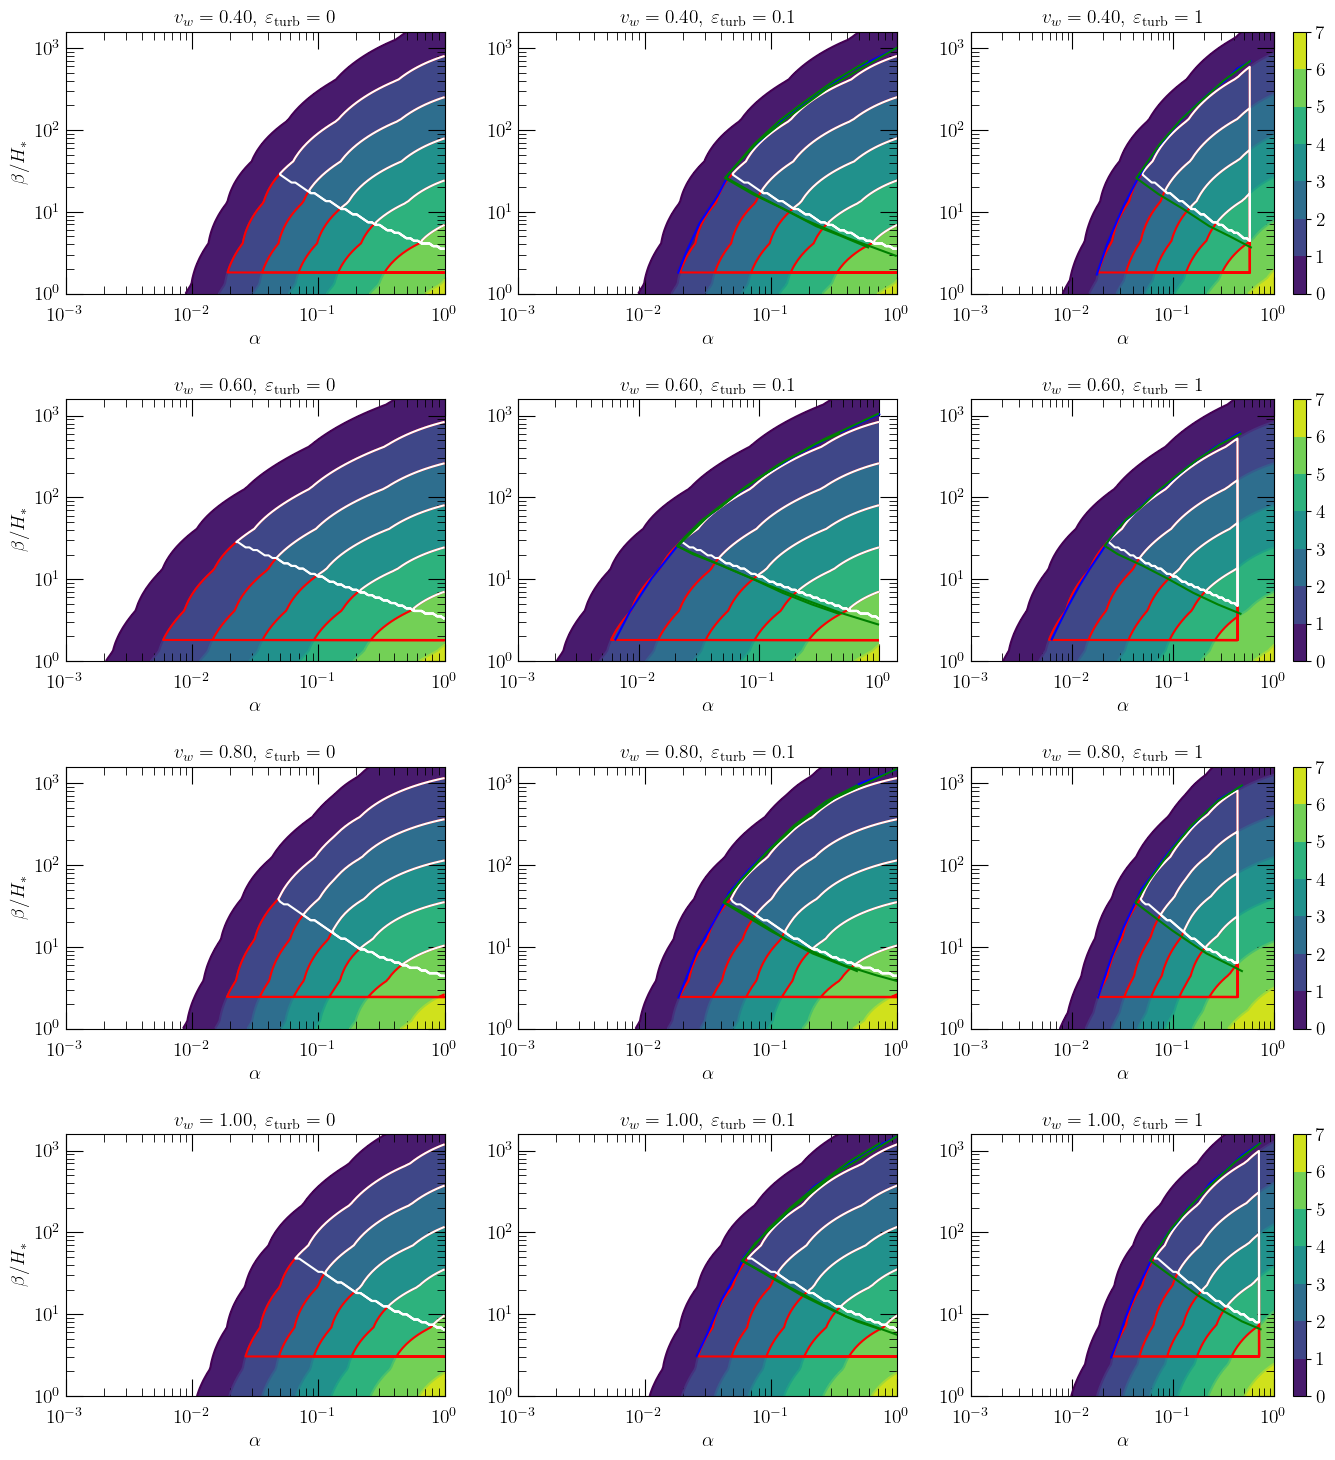

In [13]:
fig, axs = plt.subplots(4, 3, figsize=(14,15))

epss = np.array(['0', '0.1', '1'])
pos_TTs  = np.zeros((len(eps_turb), 4), dtype=poss)
pos_TTs2 = np.zeros((len(eps_turb), 4), dtype=poss)

for p in range(0, len(eps_turb)):
    l = 0
    for i in [0, 4, 8, 12]:
        # plt.figure(figsize=(8,5))
        SNR_swap = np.swapaxes(SNR_TTs[p, i], 0, 1)
        SNR_swap2 = np.swapaxes(SNR_TTs2[p, i], 0, 1)
        SNR_swap3 = np.swapaxes(SNR_TTs3[p, i], 0, 1)
        axs[l, p].tick_params(axis='x', labelsize=14)
        axs[l, p].tick_params(axis='y', labelsize=14)        
        pc = axs[l, p].contour(alphas, betas, np.log10(SNR_swap), levels=np.linspace(0, 7, 8))
        # pc2 = axs[l, p].contour(alphas, betas, np.log10(SNR_swap3), levels=np.linspace(0, 7, 8))
        pcf = axs[l, p].contourf(alphas, betas, np.log10(SNR_swap), levels=np.linspace(0, 7, 8))
        pc0 = axs[l, p].contour(alphas, betas, np.log10(SNR_swap2),  levels=np.append(-50, np.linspace(1, 7, 7)), colors='red')
        pc  = axs[l, p].contour(alphas, betas, np.log10(SNR_swap3), levels=np.append(-50, np.linspace(1, 7, 7)), colors='white')
        axs[l, p].loglog()
        axs[l, p].set_yticks(np.logspace(0, 3, 4))
        axs[l, p].set_title(r'$v_w = %.2f$, $\varepsilon_{\rm turb} = %s$'%(vws[i], epss[p]), fontsize=14)
        plot_sets.axes_lines(ax=axs[l, p])
        axs[l, p].set_xlabel(r'$\alpha$', fontsize=14)
        paths    = pc.get_paths()
        vertices = paths[1].vertices.copy()
        po = poss(vertices[:, 0], vertices[:, 1])
        pos_TTs[p, l] = po
        paths0    = pc0.get_paths()
        vertices0 = paths0[1].vertices.copy()
        po = poss(vertices0[:, 0], vertices0[:, 1])
        pos_TTs2[p, l] = po
        if i == 0:
            df = pd.read_csv('vw04_eps1.csv', names=['alp', 'bet'])
            df2 = pd.read_csv('vw04_eps1_2.csv', names=['alp', 'bet'])
            df3 = pd.read_csv('vw04_eps01.csv', names=['alp', 'bet'])
            df4 = pd.read_csv('vw04_eps01_2.csv', names=['alp', 'bet'])
        if i == 4:
            df = pd.read_csv('vw06_eps1.csv', names=['alp', 'bet'])
            df2 = pd.read_csv('vw06_eps1_2.csv', names=['alp', 'bet'])
            df3 = pd.read_csv('vw06_eps01.csv', names=['alp', 'bet'])
            df4 = pd.read_csv('vw06_eps01_2.csv', names=['alp', 'bet'])
        if i == 8:
            df = pd.read_csv('vw08_eps1.csv', names=['alp', 'bet'])
            df2 = pd.read_csv('vw08_eps1_2.csv', names=['alp', 'bet'])
            df3 = pd.read_csv('vw08_eps01.csv', names=['alp', 'bet'])
            df4 = pd.read_csv('vw08_eps01_2.csv', names=['alp', 'bet'])
        if i == 12:
            df = pd.read_csv('vw1_eps1.csv', names=['alp', 'bet'])
            df2 = pd.read_csv('vw1_eps1_2.csv', names=['alp', 'bet'])
            df3 = pd.read_csv('vw1_eps01.csv', names=['alp', 'bet'])
            df4 = pd.read_csv('vw1_eps01_2.csv', names=['alp', 'bet'])
        alps = np.array(df['alp'])
        bets = np.array(df['bet'])
        alps2 = np.array(df2['alp'])
        bets2 = np.array(df2['bet'])
        alps3 = np.array(df3['alp'])
        bets3 = np.array(df3['bet'])
        alps4 = np.array(df4['alp'])
        bets4 = np.array(df4['bet'])
        # axs[l, p].plot(pos_TTs[p, l].alphas, pos_TTs[p, l].betas, color='red', lw=2)
        # axs[l, p].plot(pos_TTs2[p, l].alphas, pos_TTs2[p, l].betas, color='red', lw=2, ls='dashed')
        if p == 0: axs[l, p].set_ylabel(r'$\beta/H_\ast$', fontsize=14)
        if p == 2:
            cbar = fig.colorbar(pcf, ax=axs[l, p])
            ticklabs = cbar.ax.get_yticklabels()
            cbar.ax.set_yticklabels(ticklabs, fontsize=14)
            axs[l, p].plot(alps, bets, color='blue')
            axs[l, p].plot(alps2, bets2, color='green')
        if p == 1:
            axs[l, p].plot(alps3, bets3, color='blue')
            axs[l, p].plot(alps4, bets4, color='green')
            axs[l, p].plot(alps2, bets2, color='green')
        l += 1
        
fig.tight_layout() 

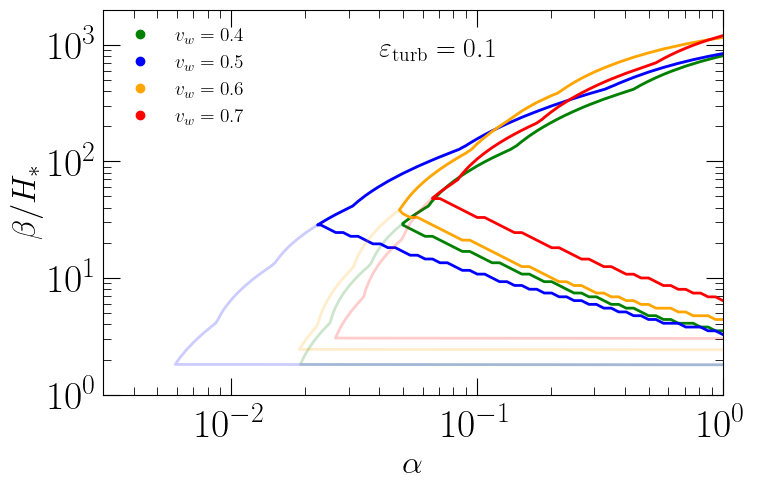

In [14]:
plt.figure(figsize=(8, 5))

cols = cmap(np.linspace(0, 1, 4))
cols = tuple(component * darken_factor for component in cols)
cols = ['green', 'blue', 'orange', 'red']
lss = ['solid', 'solid', 'dotted']

for p in [1]:
    l = 0
    for i in [0, 2, 4, 6]:
        plt.loglog(pos_TTs2[p, l].alphas,  pos_TTs2[p, l].betas, color=cols[l], ls=lss[p], lw=2, alpha=.2)
        plt.loglog(pos_TTs[p, l].alphas,  pos_TTs[p, l].betas, color=cols[l], ls=lss[p], lw=2)
        if p == 1: plt.plot([], [], 'o', color=cols[l], label=r'$v_w = %.1f$'%vws[i])
        l+= 1

plot_sets.axes_lines()
plt.text(4e-2, 8e2, r'$\varepsilon_{\rm turb} = 0.1$')
plt.xlabel(r'$\alpha$', fontsize=24)
plt.ylabel(r'$\beta/H_\ast$', fontsize=24)
plt.xlim(3e-3, 1)
plt.ylim(1, 2e3)
plt.legend(fontsize=14, loc='upper left', frameon=False, framealpha=1)

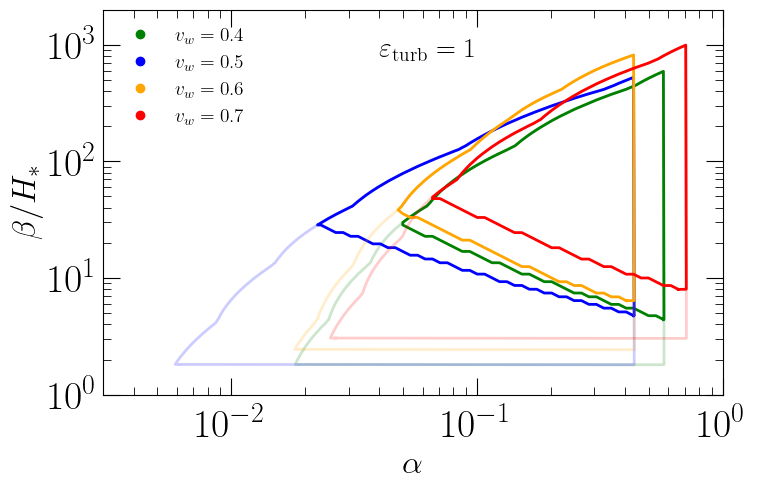

In [15]:
plt.figure(figsize=(8, 5))

cols = cmap(np.linspace(0, 1, 4))
cols = tuple(component * darken_factor for component in cols)
cols = ['green', 'blue', 'orange', 'red']
lss = ['solid', 'solid', 'solid']

for p in [2]:
    l = 0
    for i in [0, 2, 4, 6]:
        plt.loglog(pos_TTs2[p, l].alphas,  pos_TTs2[p, l].betas, color=cols[l], ls=lss[p], lw=2, alpha=.2)
        plt.loglog(pos_TTs[p, l].alphas,  pos_TTs[p, l].betas, color=cols[l], ls=lss[p], lw=2)
        if p == 2: plt.plot([], [], 'o', color=cols[l], label=r'$v_w = %.1f$'%vws[i])
        l+= 1

plot_sets.axes_lines()
plt.text(4e-2, 8e2, r'$\varepsilon_{\rm turb} = 1$')
plt.xlabel(r'$\alpha$', fontsize=24)
plt.ylabel(r'$\beta/H_\ast$', fontsize=24)
plt.xlim(3e-3, 1)
plt.ylim(1, 2e3)
plt.legend(fontsize=14, loc='upper left', frameon=False, framealpha=1)

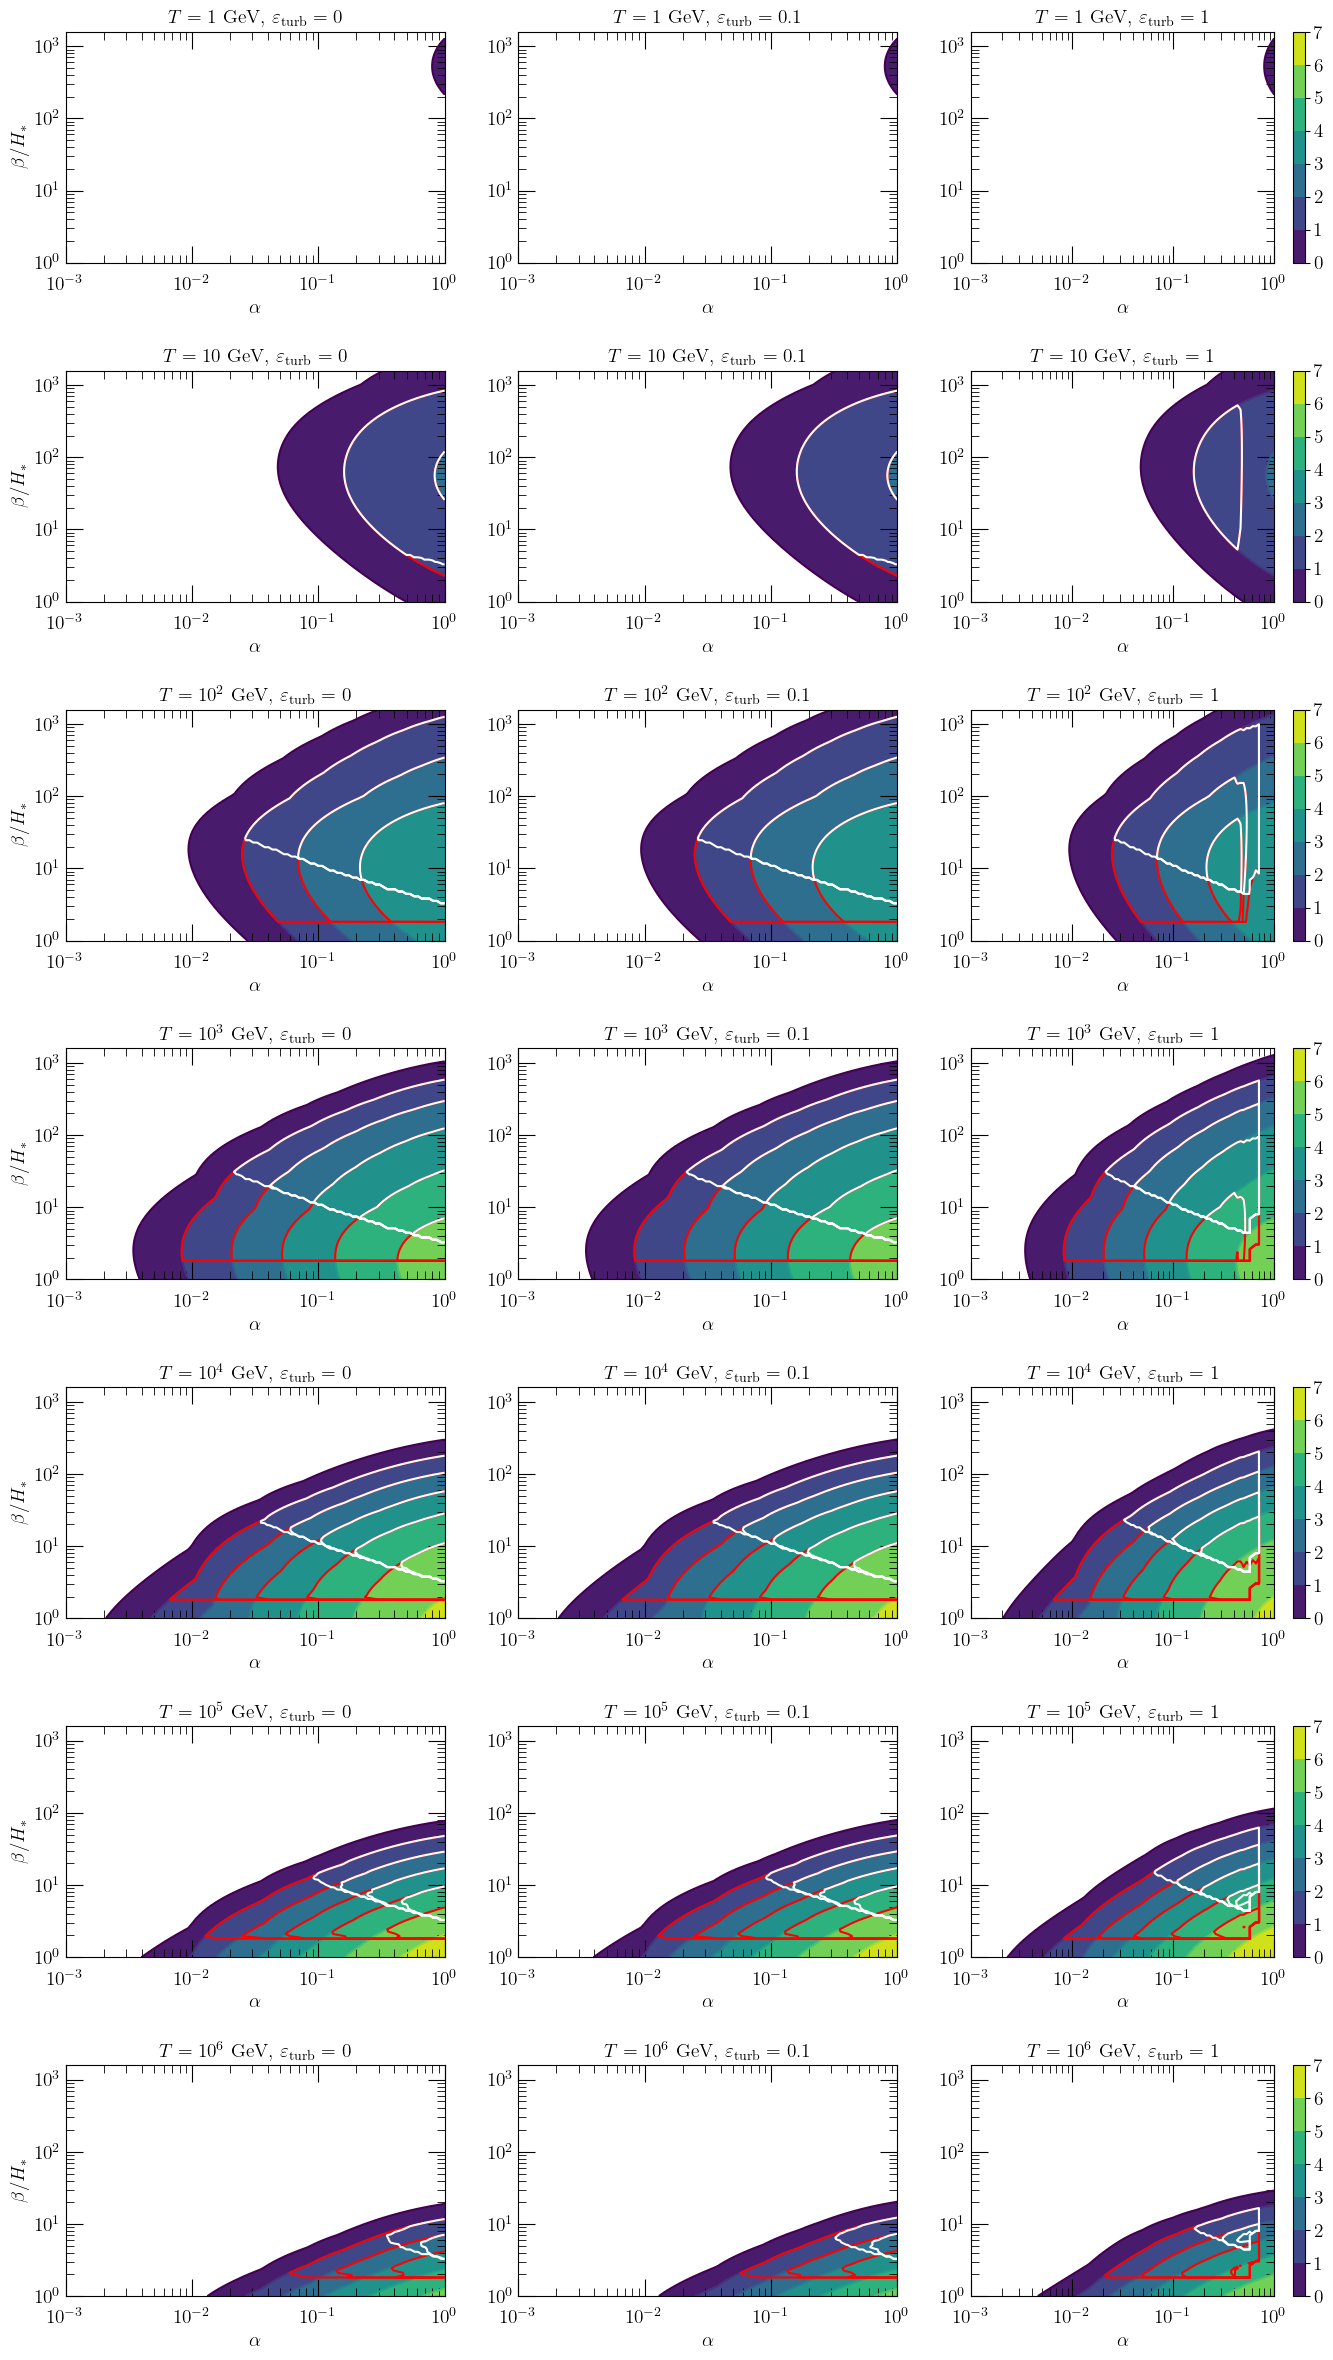

In [17]:
fig, axs = plt.subplots(7, 3, figsize=(14,24))

epss = np.array(['0', '0.1', '1'])
Tss  = ['1', '10', '10^2', '10^3', '10^4', '10^5', '10^6']

pos_vws  = np.zeros((len(eps_turb), 7), dtype=poss)
pos_vws2 = np.zeros((len(eps_turb), 7), dtype=poss)

for p in range(0, len(eps_turb)):
    l = 0
    for i in [0, 2, 4, 6, 8, 10, 12]:
        # plt.figure(figsize=(8,5))
        SNR_swap = np.swapaxes(SNR_vws[p, i], 0, 1)
        SNR_swap2 = np.swapaxes(SNR_vws2[p, i], 0, 1)
        SNR_swap3 = np.swapaxes(SNR_vws3[p, i], 0, 1)
        axs[l, p].tick_params(axis='x', labelsize=14)
        axs[l, p].tick_params(axis='y', labelsize=14)        
        pc = axs[l, p].contour(alphas, betas, np.log10(SNR_swap), levels=np.linspace(0, 7, 8))
        # pc2 = axs[l, p].contour(alphas, betas, np.log10(SNR_swap3), levels=np.linspace(0, 7, 8))
        pcf = axs[l, p].contourf(alphas, betas, np.log10(SNR_swap), levels=np.linspace(0, 7, 8))
        pc0 = axs[l, p].contour(alphas, betas, np.log10(SNR_swap2),  levels=np.append(-50, np.linspace(1, 7, 7)), colors='red')
        pc  = axs[l, p].contour(alphas, betas, np.log10(SNR_swap3), levels=np.append(-50, np.linspace(1, 7, 7)), colors='white')
        axs[l, p].loglog()
        axs[l, p].set_yticks(np.logspace(0, 3, 4))
        axs[l, p].set_title(r'$T = %s$ GeV, $\varepsilon_{\rm turb} = %s$'%(Tss[l], epss[p]), fontsize=14)
        plot_sets.axes_lines(ax=axs[l, p])
        axs[l, p].set_xlabel(r'$\alpha$', fontsize=14)
        paths    = pc.get_paths()
        vertices = paths[1].vertices.copy()
        po = poss(vertices[:, 0], vertices[:, 1])
        pos_vws[p, l] = po
        paths0    = pc0.get_paths()
        vertices0 = paths0[1].vertices.copy()
        po = poss(vertices0[:, 0], vertices0[:, 1])
        pos_vws2[p, l] = po
        # if i == 0:
        #     df = pd.read_csv('T1_eps1.csv', names=['alp', 'bet'])
        #     df2 = pd.read_csv('T1_eps01.csv', names=['alp', 'bet'])
        #     df3 = df2
        # if i == 2:
        #     df = pd.read_csv('T10_eps1.csv', names=['alp', 'bet'])
        #     df2 = pd.read_csv('T10_eps01.csv', names=['alp', 'bet'])
        #     df3 = pd.read_csv('T10_eps01_2.csv', names=['alp', 'bet'])
        # if i == 4:
        #     df = pd.read_csv('T1e2_eps1.csv', names=['alp', 'bet'])
        #     df2 = pd.read_csv('T1e2_eps01.csv', names=['alp', 'bet'])
        #     df3 = pd.read_csv('T1e2_eps01_2.csv', names=['alp', 'bet'])
        # if i == 6:
        #     df = pd.read_csv('T1e3_eps1.csv', names=['alp', 'bet'])
        #     df2 = pd.read_csv('T1e3_eps01.csv', names=['alp', 'bet'])
        #     df3 = pd.read_csv('T1e3_eps01_2.csv', names=['alp', 'bet'])
        #     # df2 = pd.read_csv('vw1_eps1_2.csv', names=['alp', 'bet'])
        # if i == 8:
        #     df = pd.read_csv('T1e4_eps1.csv', names=['alp', 'bet'])
        #     df2 = pd.read_csv('T1e4_eps01.csv', names=['alp', 'bet'])
        #     df3 = pd.read_csv('T1e4_eps01_2.csv', names=['alp', 'bet'])
        #     # df2 = pd.read_csv('vw1_eps1_2.csv', names=['alp', 'bet'])
        # if i == 10:
        #     df = pd.read_csv('T1e5_eps1.csv', names=['alp', 'bet'])
        #     df2 = pd.read_csv('T1e5_eps01.csv', names=['alp', 'bet'])
        #     df3 = pd.read_csv('T1e5_eps01_2.csv', names=['alp', 'bet'])
        #     # df2 = pd.read_csv('vw1_eps1_2.csv', names=['alp', 'bet'])
        # if i == 12:
        #     df = pd.read_csv('T1e6_eps1.csv', names=['alp', 'bet'])
        #     df2 = pd.read_csv('T1e6_eps01.csv', names=['alp', 'bet'])
        #     df3 = df2
        #     # df2 = pd.read_csv('vw1_eps1_2.csv', names=['alp', 'bet'])
        # alps = np.array(df['alp'])
        # bets = np.array(df['bet'])
        # alps2 = np.array(df2['alp'])
        # bets2 = np.array(df2['bet'])
        # alps3 = np.array(df3['alp'])
        # bets3 = np.array(df3['bet'])
        # axs[l, p].plot(pos_TTs[p, l].alphas, pos_TTs[p, l].betas, color='red', lw=2)
        # axs[l, p].plot(pos_TTs2[p, l].alphas, pos_TTs2[p, l].betas, color='red', lw=2, ls='dashed')
        if p == 0: axs[l, p].set_ylabel(r'$\beta/H_\ast$', fontsize=14)
        if p == 2:
            cbar = fig.colorbar(pcf, ax=axs[l, p])
            ticklabs = cbar.ax.get_yticklabels()
            cbar.ax.set_yticklabels(ticklabs, fontsize=14)
            # axs[l, p].plot(alps, bets, color='blue')
        # if p == 1:
        #     axs[l, p].plot(alps2, bets2, color='blue')
        #     axs[l, p].plot(alps3, bets3, color='green')
        l += 1
        
fig.tight_layout() 

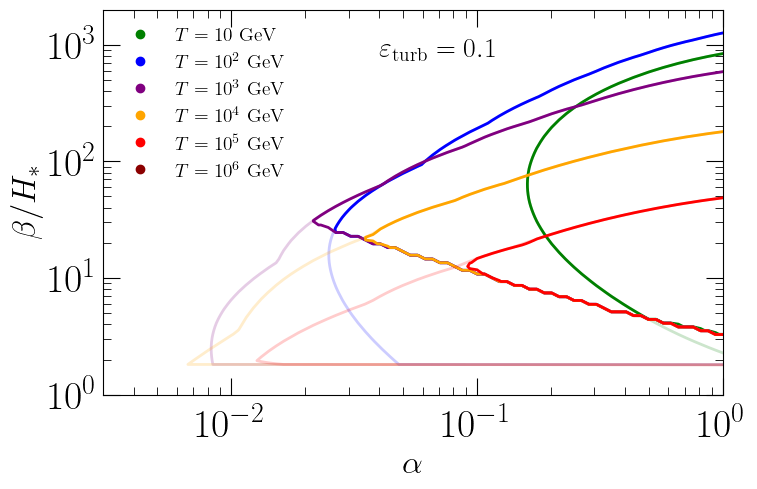

In [18]:
plt.figure(figsize=(8, 5))

cols = ['darkgreen', 'green', 'blue', 'purple', 'orange', 'red', 'darkred']
lss = ['solid', 'solid', 'dotted']

for p in [1]:
    l = 0
    for i in [2, 4, 6, 8, 10, 12]:
        plt.loglog(pos_vws2[p, l].alphas,  pos_vws2[p, l].betas, color=cols[l], ls=lss[p], lw=2, alpha=.2)
        plt.loglog(pos_vws[p, l].alphas,  pos_vws[p, l].betas, color=cols[l], ls=lss[p], lw=2)
        if p == 1: plt.plot([], [], 'o', color=cols[l + 1], label=r'$T = %s$ GeV'%Tss[l + 1])
        l+= 1

plot_sets.axes_lines()
plt.text(4e-2, 8e2, r'$\varepsilon_{\rm turb} = 0.1$')
plt.xlabel(r'$\alpha$', fontsize=24)
plt.ylabel(r'$\beta/H_\ast$', fontsize=24)
plt.xlim(3e-3, 1)
plt.ylim(1, 2e3)
plt.legend(fontsize=14, loc='upper left', frameon=False, framealpha=1)

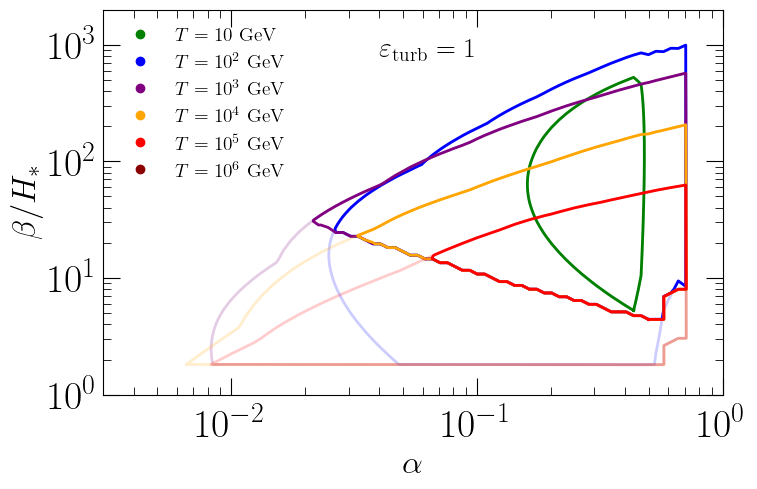

In [19]:
plt.figure(figsize=(8, 5))

cols = ['darkgreen', 'green', 'blue', 'purple', 'orange', 'red', 'darkred']
lss = ['solid', 'solid', 'solid']

for p in [2]:
    l = 0
    for i in [2, 4, 6, 8, 10, 12]:
        plt.loglog(pos_vws2[p, l].alphas,  pos_vws2[p, l].betas, color=cols[l], ls=lss[p], lw=2, alpha=.2)
        plt.loglog(pos_vws[p, l].alphas,  pos_vws[p, l].betas, color=cols[l], ls=lss[p], lw=2)
        if p == 2: plt.plot([], [], 'o', color=cols[l + 1], label=r'$T = %s$ GeV'%Tss[l + 1])
        l+= 1

plot_sets.axes_lines()
plt.text(4e-2, 8e2, r'$\varepsilon_{\rm turb} = 1$')
plt.xlabel(r'$\alpha$', fontsize=24)
plt.ylabel(r'$\beta/H_\ast$', fontsize=24)
plt.xlim(3e-3, 1)
plt.ylim(1, 2e3)
plt.legend(fontsize=14, loc='upper left', frameon=False, framealpha=1)